In [46]:
import pickle as pkl
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
from scipy.optimize import curve_fit
# import pylandau as pland
# import ROOT
import scipy.ndimage as ndimage
import numpy.ma as ma
from functions_CONNIE import *
from ROOT import TF1, TGraph, TLegend, TFile, TTree

def gaussian(x, a, mean, sigma, y_move):
    return a * np.exp(-((x - mean)**2 / (2 * sigma**2))) - y_move

# def gaussian(x, a, mean, sigma):
#     return a * np.exp(-((x - mean)**2 / (2 * sigma**2))) 

def diffution_curve(z, alpha, beta):
    return np.sqrt(np.abs(alpha * np.log(1 - (beta * z))))
    
from reportlab.pdfgen import canvas
from reportlab.lib.pagesizes import A4, letter
from reportlab.lib.utils import ImageReader

In [47]:
import matplotlib.colors


plt.rcParams.update({
    "image.origin": "lower",
    "image.aspect": 1,
    #"text.usetex": True,
    "grid.alpha": .5,
    "axes.linewidth":2,
    "lines.linewidth" : 1,
    "font.size":    15.0,
    "xaxis.labellocation": 'right',  # alignment of the xaxis label: {left, right, center}
    "yaxis.labellocation": 'top',  # alignment of the yaxis label: {bottom, top, center}
    "xtick.top":           True ,  # draw ticks on the top side
    "xtick.major.size":    8    ,# major tick size in points
    "xtick.minor.size":    4      ,# minor tick size in points
    "xtick.direction":     'in',
    "xtick.minor.visible": True,
    "ytick.right":           True ,  # draw ticks on the top side
    "ytick.major.size":    8    ,# major tick size in points
    "ytick.minor.size":    4      ,# minor tick size in points
    "ytick.direction":     'in',
    "ytick.minor.visible": True,
    "ytick.major.width":   2   , # major tick width in points
    "ytick.minor.width":   1 ,
    "xtick.major.width":   2   , # major tick width in points
    "xtick.minor.width":   1 ,
    "legend.framealpha": 0 ,
    "legend.loc": 'best',

})

ColorMap = 'jet'
Norm = matplotlib.colors.LogNorm(vmin=10**-1, vmax=5 * 10**0)

In [48]:
# path = './Diccionarios_Espetro_Muones/dict_straight_muons_Extensions_1_to_4_Imgs_189_Elip_0.9_Sol_0.65_Skirts_0_NSIGMAS_13_KeV__NSAMP324.pkl'
# path = './Diccionarios_Espetro_Muones/dict_straight_muons_Extensions_1_to_4_Imgs_189_Elip_0.9_Sol_0.65_Skirts_0_NSIGMAS_20_KeV__NSAMP324.pkl'
path = './dict_muons_NSAMP400_CONNIE_RUNID_116_NIMG_684_NSIG_4_SOL_0.65_ELIP_0.65_DEDL_1300_SIZE_1022x420_KeV_new.pkl'


histogram = open(path, 'rb')
data_histogram = pkl.load(histogram)
histogram.close()

#### Visualizar las keys del diccionario ####
print('Las unidades de los datos están en: ', data_histogram['Energy_Units'])
print('Llaves principales del diccionario: ', data_histogram.keys())
print('Llaves secuandarias por extensión: ', data_histogram['extension_1'].keys(), end='\n\n')
# print(type(data_histogram['extension_1']['all_events']))
# data_muons_extension_1 = data_histogram['extension_1']
# data_muons_extension_2 = data_histogram['extension_2']
# data_muons_extension_4 = data_histogram['extension_4']
Ext = 1

n_muons = data_histogram['All_Muons_Detected']
print('Se detectaron ', n_muons, ' muones (contando las 3 extensiones)')
DF_muons, list_datamask = DataFrame_muons(data_histogram, extension=Ext)

Las unidades de los datos están en:  2
Llaves principales del diccionario:  dict_keys(['Num_Images', 'All_Muons_Detected', 'Energy_Units', 'Elipcidad', 'Solidity', 'extension_1'])
Llaves secuandarias por extensión:  dict_keys(['charge', 'deltaEL', 'deltaL', 'all_events', 'theta', 'phi', 'elip', 'sol', 'all_events_elip', 'all_events_sol', 'datamasked'])

Se detectaron  8549  muones (contando las 3 extensiones)


# Extension 1

### Muones verticales

#### DataFrame y visualización

In [49]:
### Se crea el dataframe y se selecciona un rango de datos ###
Ext = 1
DF_muons, list_datamask = DataFrame_muons(data_histogram, extension=Ext)
# display(DF_muons[450:500])
list_newmatrix = []
list_indexs =[]
# range_in_phi = DF_muons[DF_muons['Phi (Deg)'].between(85, 95)] # Verticales arriba
range_in_phi = DF_muons[DF_muons['Phi (Deg)'].between(265, 275)] # Verticales abajo

for index in range_in_phi.index:
    # print(index)
    list_newmatrix.append(list_datamask[index])
    list_indexs.append(index)

print(f'Muons detected in the range: {len(list_newmatrix)}')
print(list_indexs)
list_phi_ext1 = data_histogram['extension_' + str(Ext)]['phi']
list_mask_rot = []

list_listsnxny = []

for index in list_indexs[:]:
    datamask = list_datamask[index]
    ylen, xlen = datamask.shape
    list_nxny = []

    data_mask_zeros = np.empty((ylen + 90, xlen+50))
    data_mask_zeros[:] = 0
    ylen_zeros, xlen_zeros = data_mask_zeros.shape
    # print(data_mask_zeros.shape)
    
    ### Angle rot ##
    phi_rot = np.pi/2 - list_phi_ext1[index]
    # print(phi_rot, phi_rot + list_phi_ext1[index])

    # print('shape original: ', xlen, ylen)
    # print('shape zeros: ', xlen_zeros, ylen_zeros)

    for y_bin in range(0, ylen):
        for x_bin in range(0, xlen):
            if datamask[y_bin][x_bin] != 0:
                nx, ny = pixel_rot(x_bin=x_bin, x0=0, y_bin=y_bin, y0=0, theta= phi_rot)
                list_nxny.append((nx + 10, ny))
                # print(nx, ny)
                data_mask_zeros[ny][nx+10] = datamask[y_bin][x_bin]

    list_listsnxny.append(list_nxny)
    label_img, nlabels_img = sk.measure.label(data_mask_zeros > 0, connectivity=2, return_num=True)
    loc = nd.find_objects(label_img == 1)[0]
    mask_rot = np.invert(label_img==1)
    # data_mask_rot = ma.masked_array(data_mask_zeros, mask_rot)
    data_mask_rot = ma.masked_array(data_mask_zeros[loc[0].start:loc[0].stop, loc[1].start:loc[1].stop], mask_rot[loc[0].start:loc[0].stop, loc[1].start:loc[1].stop])

    list_mask_rot.append(data_mask_rot)
    # print('Shape rot: ', data_mask_rot.shape[1], data_mask_rot.shape[0])
    
    # plt.imshow(data_mask_rot)
    # plt.show()

# print(list_mask_rot)
#     

Muons detected in the range: 369
[1, 24, 56, 63, 68, 75, 93, 96, 111, 189, 247, 282, 294, 318, 346, 357, 393, 396, 398, 415, 423, 440, 454, 460, 518, 544, 559, 572, 577, 596, 605, 654, 733, 745, 782, 851, 894, 895, 932, 935, 940, 941, 954, 960, 969, 996, 1015, 1042, 1083, 1084, 1095, 1096, 1113, 1126, 1159, 1170, 1214, 1215, 1229, 1233, 1246, 1259, 1275, 1276, 1285, 1318, 1323, 1329, 1332, 1352, 1410, 1423, 1532, 1560, 1571, 1609, 1679, 1704, 1761, 1777, 1784, 1788, 1835, 1859, 1867, 1883, 1918, 1922, 1925, 1943, 1967, 2107, 2155, 2178, 2203, 2212, 2272, 2289, 2343, 2354, 2359, 2361, 2389, 2480, 2486, 2510, 2562, 2570, 2617, 2683, 2776, 2780, 2787, 2793, 2825, 2828, 2832, 2851, 2903, 2904, 2944, 2954, 2961, 2985, 3014, 3037, 3038, 3069, 3092, 3095, 3127, 3128, 3158, 3170, 3197, 3204, 3241, 3254, 3267, 3271, 3283, 3302, 3367, 3377, 3394, 3395, 3454, 3482, 3524, 3525, 3538, 3540, 3575, 3577, 3594, 3689, 3719, 3731, 3800, 3826, 3883, 3885, 3894, 3903, 3930, 3940, 3944, 3950, 3955, 3973, 3

,Solidity,Elipticity,Theta (Deg),Phi (Deg),Charge (KeV),l (cm),dEdL (KeV/cm)
Muon ID,,,,,,,
1,0.742331,0.859629,46.618161,273.38655,1.196825,0.098274,12.178488


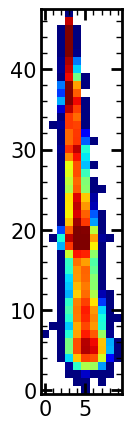

In [50]:
# [19, 312, 320, 348, 599,
n_label = 1
display(DF_muons.iloc[[n_label]])

figure , axs = plt.subplots(1,1,figsize=[5,5])
# axs.imshow(list_mask_rot[n_label],  cmap = ColorMap, norm=Norm)  # 77, 1911, 2381, 2930 indices para path con elip 0.85, Sol 0.7
axs.imshow(list_datamask[n_label],  cmap = ColorMap, norm=Norm)  # 77, 1911, 2381, 2930 indices para path con elip 0.85, Sol 0.7
plt.show()


Label muons:  1
Number of rows:  48
Line number:  20
Long of line:  8


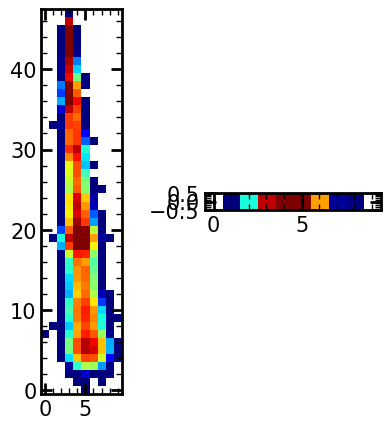

In [51]:
figure , axs = plt.subplots(1,2,figsize=[5,5])

label_muon = n_label
label_line = 20
muon = list_datamask[label_muon]

print('Label muons: ', label_muon)
print('Number of rows: ', muon.shape[0])
print('Line number: ', label_line)
line = list_datamask[label_muon][label_line - 1:label_line][0]

n_longline = 0
for pixel in line:
    if pixel != 0:
        # print(pixel)
        n_longline += 1

print('Long of line: ', n_longline)

axs[0].imshow(list_datamask[label_muon], cmap=ColorMap ,norm = Norm)
axs[1].imshow(list_datamask[label_muon][label_line - 1:label_line], cmap=ColorMap, norm = Norm)
plt.show()

In [52]:
list_index_long_muons = []
extension = 1

for index in range(0, len(list_newmatrix)):
    size_x = list_newmatrix[index].shape[1]
    size_y = list_newmatrix[index].shape[0]
    if size_y > 50:
        # print(size_x, size_y)
        list_index_long_muons.append(list_indexs[index])

# print(list_index_long_muons)+
print('Muones largos detectados: ', len(list_index_long_muons))
print('Indices: ', list_index_long_muons)

Muones largos detectados:  83
Indices:  [68, 189, 282, 396, 398, 415, 440, 572, 782, 969, 996, 1042, 1095, 1275, 1285, 1609, 1788, 1967, 2343, 2354, 2510, 2776, 2825, 2904, 2961, 2985, 3037, 3069, 3158, 3197, 3241, 3254, 3271, 3577, 3594, 3885, 3940, 3944, 3955, 3983, 4298, 4521, 4769, 5124, 5207, 5398, 5413, 5414, 5504, 5649, 5964, 6131, 6246, 6275, 6313, 6409, 6435, 6494, 6502, 6764, 6872, 6897, 6914, 7088, 7115, 7182, 7229, 7312, 7323, 7488, 7587, 7628, 7776, 7859, 7874, 7893, 7975, 7984, 8194, 8216, 8503, 8513, 8533]


#### Perfil Energético

46.61816064146138
Number of rows:  64


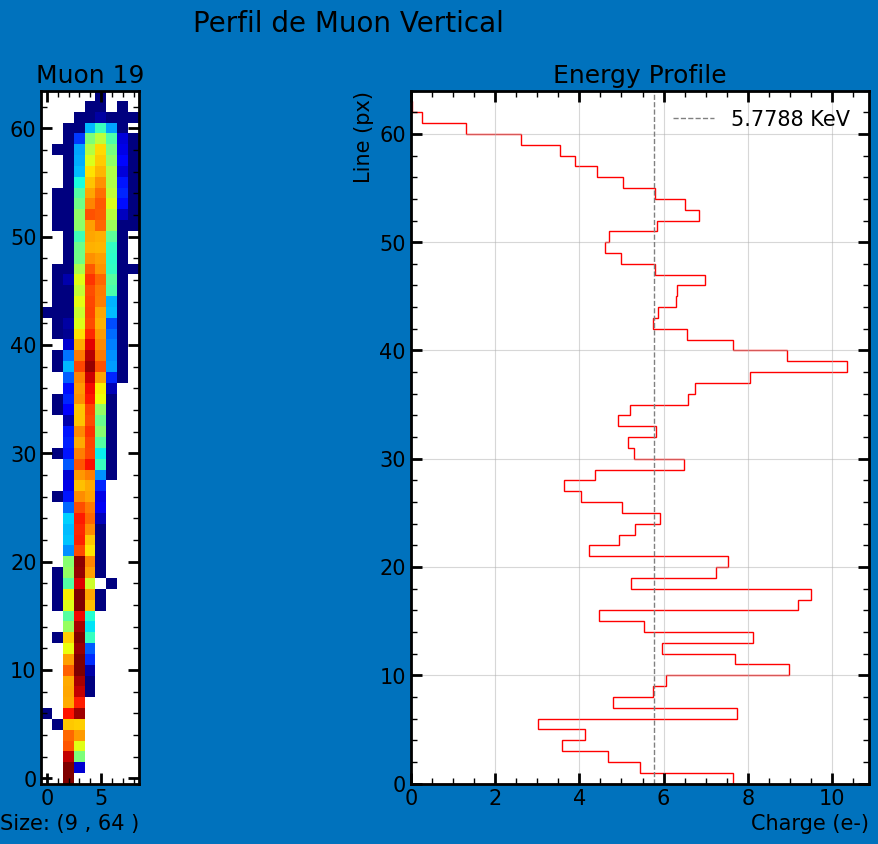

In [53]:
# list_muonlabels = [10, 15, 74, 91, 92, 112, 133, 176, 196, 256]  # Segunda revisión (están arriba)
muon_label = 19  # Se coloca directamente el label del evento
thet = DF_muons.iloc[[n_label]]['Theta (Deg)'].values[0]
print(thet)

Delta_inicial = 0
Delta_final = 0
extension = 1

fig, axs = plt.subplots(ncols=2, nrows=1, figsize = [13,9], facecolor = [0, 0.4470, 0.7410])
fig.suptitle('Perfil de Muon Vertical', y = 0.97, size = 20)
event = list_datamask[muon_label]
# plt.imshow(event)

size_x = event.shape[1] # tamaño en x
size_y = event.shape[0] # tamaño en y
# print(event.sum())

print('Number of rows: ', event.shape[0])
charge_verticalMuon = []
for index in range(1, size_y):
    line = event[index - 1:index][0]
    charge = line.sum()
    charge_verticalMuon.append(charge)

        
# cmap = 'plasma'
axs[0].imshow(event, cmap = ColorMap, norm = Norm)#, origin='upper')
axs[0].set_title('Muon ' + str(muon_label))
axs[0].set_xlabel('Size: (' + str(size_x) + ' , ' + str(size_y) + ' )')
# x0bar = fig.colorbar(x0, ax=axs[0])

en_cor = 4.2 /np.sin(np.radians(thet))
axs[1].stairs(charge_verticalMuon, range(0,len(charge_verticalMuon)+1),  orientation='horizontal', color = 'r')#,  hatch = '////')
axs[1].axvline(en_cor, 0, size_y+2, linestyle='--', color='gray', label = str(np.around(en_cor, 4)) +' KeV')
# axs[1].vlines(x = mean_charge, ymin = 0, ymax = len(event) - 1, color = 'k', label = 'Mean Charge \n' + str(mean_charge))

axs[1].set_ylim(0, size_y)
# axs[1].set_xlim(0, 4000)


# axs[1].set_xlabel('Charge (KeV)')
axs[1].set_xlabel('Charge (e-)')
axs[1].set_ylabel('Line (px)')
# axs[1].set_ylim(0,len(event) - 1 )
axs[1].set_title('Energy Profile')
axs[1].legend()
axs[1].grid()
plt.show()

#### Modelo de Difusión

In [ ]:
CCD_depth = 680 # micras
Delta_inicial = 3    # px
Delta_final = 6     # px
Bins = 50

ratio_KeVelec = 0.0368 #KeV/e-
extension = 1
label_muon = 19
lable_line = 30
# img_sigma = 0.0005  # KeV 
img_sigma = 0.14417 # e-
# print(img_sigma)

## Se checa si el muon tiene la orientación correcta
event = list_datamask[label_muon]
size_x = event.shape[1]
size_y = event.shape[0]

# lines = 0
Longitud_XY = size_y 
Longitud_linea = size_x

Z_inicial = (Delta_inicial * CCD_depth) / (Longitud_XY - Delta_final)


line = event[lable_line - 1:lable_line][0]
Carga_renglon = line.sum()/ratio_KeVelec
Mean_carga = np.mean(line)/ratio_KeVelec


Mean_in  = 0
var = 0
carga_cuadrada = 0
pixels_with_charge = 0

### Se calcula el X promedio ##
for pixel in np.arange(0, Longitud_linea, 1):
    if line[pixel]:
        pixels_with_charge+=1
        element_pixel = (pixel * line[pixel]/ratio_KeVelec) / Carga_renglon
        Mean_in = Mean_in + element_pixel
    else:
        element_pixel = 0
    
    Mean_in = Mean_in + element_pixel

print("Pixels with charge: {}".format(pixels_with_charge))
print("Label Line: {}".format(lable_line))
## Calcula la suma de las cargas al cuadrado ##
for pixel in np.arange(0, Longitud_linea, 1):
    if line[pixel]:
        element_pixel = (line[pixel]/ratio_KeVelec)**2
    else:
        element_pixel = 0

    carga_cuadrada = carga_cuadrada + element_pixel 

Mean_carga_cuadrada = carga_cuadrada/Longitud_linea

### Se calcula la varianza ##
for pixel in np.arange(0, Longitud_linea, 1):
    element_pixel =(1 / (Longitud_linea - 1)) * (pixel - Mean_in)**2
    var = var + element_pixel  ### COreggir la varianza con otro estimados

### Se corrige la varianza con la carga ###
var_true = var * (Mean_carga_cuadrada / (Mean_carga**2))

### Se calcula la sigma ###
sigma_in = np.sqrt(var)
# sigma_in = np.sqrt(var_true)


##Se crea un arreglo para usarlo en el plot de los datos, y se realiza el juste ##
list_xlabel = np.arange(0.5, len(line), 1)

# list_xlabel_long = np.linspace(-Longitud_linea + int(Longitud_linea/2) , Longitud_linea + int(Longitud_linea/2), Longitud_linea)

# popt, pcov = curve_fit(gaussian, list_xlabel, data_mask[0], maxfev=100000, p0 = [8000, Mean_in, sigma_in])		# Fit histogram with gaussian

print('Lonitud de la linea: ', len(line.flatten()))

## Ajuste gaussiano con ROOT ##
fgaus2 = TF1("fgauss","gaus",  0,  len(line.flatten()), 3) # TF1("nombre", "funcion escrita como en root", min, max, #parametros)
h3=TH1F("histogram", "Line Distribution: {}".format(lable_line), len(line.flatten()) + 1, 0,  len(line.flatten()) )
h3.GetYaxis().SetTitle("Charge (e-)")
h3.GetXaxis().SetTitle("Position (px)")
h3.SetStats(0)
# h3.GetYaxis().SetRangeUser(0, 170)

for index in range(0, len(line)):
    if line[index]:
        # print(index, line[index])
        h3.SetBinContent( index + 1, line[index]/ratio_KeVelec)
        err = np.sqrt((img_sigma/ratio_KeVelec)**2 + line[index]/ratio_KeVelec)
        h3.SetBinError(index + 1,err )
        # h3.SetBinError(index + 1, img_sigma)
        # h3.SetBinError(index + 1, 0.001)
        #print(pixel_value)

fgaus2.SetParameters(np.max(line),Mean_in,sigma_in) # Establecer parametros iniciales del fit, de manera visual es posible determinarlos como una primera aproximacion
h3.Fit(fgaus2, "RNQL")

fit_const = fgaus2.GetParameters()[0]
fit_mean = fgaus2.GetParameters()[1]
fit_sigma = fgaus2.GetParameters()[2]
chisquare = fgaus2.GetChisquare()
NDFval = fgaus2.GetNDF()
print('Sigma fit: ', fit_sigma, end='\n\n')

leg = TLegend(0.1,0.7,0.48,0.9)
leg.AddEntry(fgaus2, r"Gaussian Fit:", "L")
leg.AddEntry(0, r"\mu= {} #pm {} px".format(np.around(fit_mean, 3), np.around(fgaus2.GetParErrors()[1], 3)), "")
# leg.AddEntry(0, "Some text", "");
leg.AddEntry(0, r" \sigma= {} #pm {} px".format(np.around(fit_sigma, 3), np.around(fgaus2.GetParErrors()[2], 3)), "")
leg.AddEntry(0, r" #chi^2/NDF= {} / {}".format(np.around(chisquare, 3), np.around(NDFval, 3)), "")
leg.AddEntry(h3, r" Pixels with charge: {} ".format(pixels_with_charge), "L")
leg.Draw()

c3=TCanvas()
c3.SetGrid()

h3.Draw()
c3.Draw()
fgaus2.Draw("same")
leg.Draw("same")
# gStyle.SetOptFit(1100)
# gStyle.SetPadGridX (True)



# plt.show()

Pixels with charge: 5
Label Line: 30
Lonitud de la linea:  9
Sigma fit:  0.614258209196168



Total Muons: 45


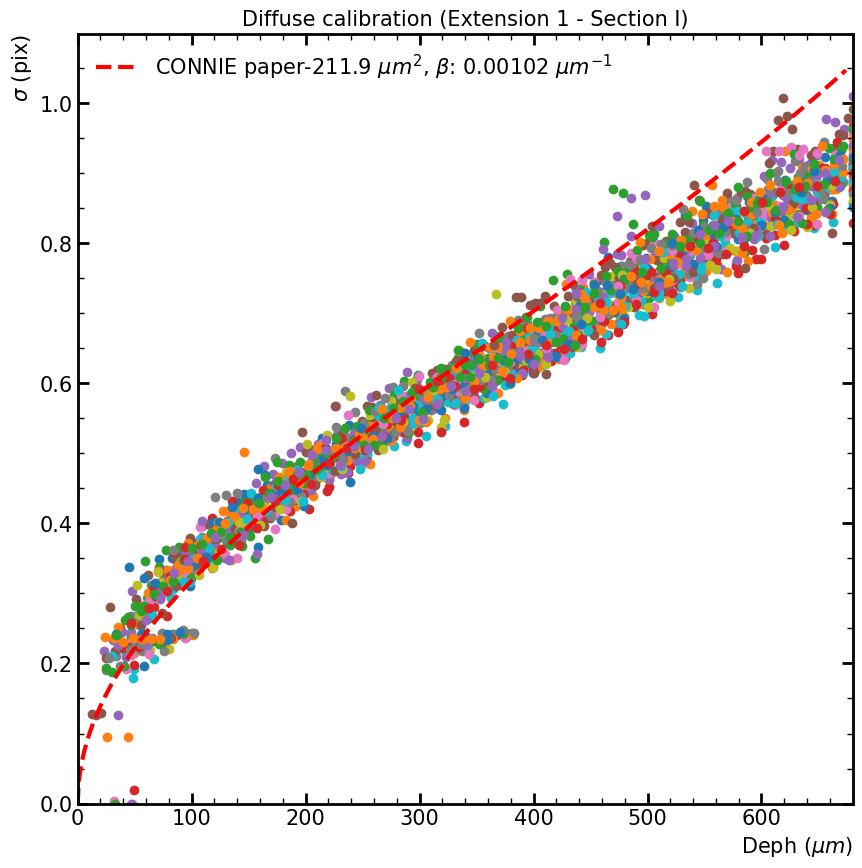

Warning in <TROOT::Append>: Replacing existing TH1: histogram (Potential memory leak).


In [ ]:
CCD_depth = 680 # micras
Bins = 50

extension = 1
label_muon = 1
img_sigma = 0.0003  # KeV 
# print(img_sigma)
fig, axs_all = plt.subplots(figsize = [10,10])


# Data 265 to 275 
#  [68, 189, 282, 396, 398, 415, 440, 572, 782, 969, 996, 1042, 1095, 1275, 
#   1285, 1609, 1788, 1967, 2343, 2354, 2510, 2776, 2825, 2904, 2961, 2985, 
#   3037, 3069, 3158, 3197, 3241, 3254, 3271, 3577, 3594, 3885, 3940, 3944, 
#   3955, 3983, 4298, 4521, 4769, 5124, 5207, 5398, 5413, 5414, 5504, 5649, 
#   5964, 6131, 6246, 6275, 6313, 6409, 6435, 6494, 6502, 6764, 6872, 6897, 
#   6914, 7088, 7115, 7182, 7229, 7312, 7323, 7488, 7587, 7628, 7776, 7859, 
#   7874, 7893, 7975, 7984, 8194, 8216, 8503, 8513, 8533]



# Verticales 90°
# [19, 312, 320, 348, 599, 730, 1554, 1851, 2022, 2574, 2613, 2744, 2752, 3319, 3488, 3866, 4114, 4831, 4958, 5360, 5937, 5980, 6290, 6486, 6703, 7096, 7752, 7935, 8217]


# 19, 312, 320, 348, 730, 886, 1267, 1554, 1688, 1697, 1724, 1806, 1834, 1937, 2574, 2744, 3075,3418, 3521, 3602, 3636, 3818, 4114, 4227,
# 4451, 4592, 4678, 4958, 5252, 5360, 5514, 5937, 5980, 6290, 6351, 6460, 6508, 6703, 6731, 6746 7096, 7752, 7761, 8081, 8158
list_muonlabels0 = [19, 312, 320, 348, 730, 886, 1267, 1554, 1688, 1697, 1724, 1806, 
                    1834, 1937, 2574, 2744, 3075, 3418, 3521, 3602, 3636, 3818, 4114, 
                    4227, 4451, 4592, 4678, 4958, 5252, 5360, 5514, 5937, 5980, 6290, 
                    6351, 6460, 6508, 6703, 6731, 6746, 7096, 7752, 7761, 8081, 8158]


list_muonlabels1 = [100000]

# list_muonlabels = list_muonlabels0 + list_muonlabels1
list_muonlabels = list_muonlabels0

print('Total Muons: {}'.format(len(list_muonlabels)))
for label_muon in list_muonlabels: 
    Delta_inicial = 3    # px
    Delta_final = 6     # px
    event = list_datamask[label_muon]
    size_x = event.shape[1]
    size_y = event.shape[0]

    # lines = 0
    Longitud_XY = size_y 
    Z_inicial = (Delta_inicial * CCD_depth) / (Longitud_XY - Delta_final)
    # print('Muon: ', label_muon, ', Shape (X, Y): ', event.shape[1], event.shape[0])

    list_fitsigmas = []
    if label_muon in list_muonlabels1:
        Delta_inicial = Delta_final
        Delta_final = Delta_inicial


    for lable_line in range(Delta_inicial, size_y - Delta_final):
        line = event[lable_line - 1:lable_line][0]
        Carga_renglon = line.sum()/ratio_KeVelec
        Mean_carga = np.mean(line)/ratio_KeVelec
        Longitud_linea = len(line)


        Mean_in  = 0
        var = 0
        carga_cuadrada = 0

        ### Se calcula el X promedio ##
        for pixel in range(0, Longitud_linea):
            if line[pixel]:
                element_pixel = (pixel * line[pixel]/ratio_KeVelec) / Carga_renglon
                Mean_in = Mean_in + element_pixel
            else:
                element_pixel = 0
            
            Mean_in = Mean_in + element_pixel

        ## Calcula la suma de las cargas al cuadrado ##
        for pixel in np.arange(0, Longitud_linea, 1):
            if line[pixel]:
                element_pixel = (line[pixel]/ratio_KeVelec)**2
            else:
                element_pixel = 0

            carga_cuadrada = carga_cuadrada + element_pixel 

        Mean_carga_cuadrada = carga_cuadrada/Longitud_linea

        ### Se calcula la varianza ##
        for pixel in np.arange(0, Longitud_linea, 1):
            if line[pixel]:
                # element_pixel =(1 / (Longitud_linea - 1)) * (pixel - Mean_in)**2 * line[pixel]
                element_pixel =(1 / (Longitud_linea - 1)) * (pixel - Mean_in)**2
                var = var + element_pixel  ### COreggir la varianza con otro estimados

        ### Se corrige la varianza con la carga ###
        var_true = var * (Mean_carga_cuadrada / (Mean_carga**2))
        # var_true = var / Carga_renglon

        ### Se calcula la sigma ###
        sigma_in = np.sqrt(var_true)
        # print(sigma_in)
        # sigma_in = np.sqrt(var_true)


        ##Se crea un arreglo para usarlo en el plot de los datos, y se realiza el juste ##
        list_xlabel = np.arange(0.5, len(line), 1)


        ## Ajuste gaussiano con ROOT ##
        fgaus2 = TF1("fgauss","gaus",  0,  len(line.flatten()), 3) # TF1("nombre", "funcion escrita como en root", min, max, #parametros)
        h3=TH1F("histogram", "Distribution of Line", len(line.flatten()) + 1, 0,  len(line.flatten()) )

        for index in range(0, len(line)):
            if line[index] != 0:
                # print(index, line[index])
                h3.SetBinContent( index + 1, line[index]/ratio_KeVelec)
                err = np.sqrt((img_sigma/ratio_KeVelec)**2 + line[index]/ratio_KeVelec)
                h3.SetBinError(index + 1,err )
                # h3.SetBinError(index + 1, img_sigma)
                # h3.SetBinError(index + 1, 0.001)
                #print(pixel_value)

        fgaus2.SetParameters(np.max(line),Mean_in,sigma_in) # Establecer parametros iniciales del fit, de manera visual es posible determinarlos como una primera aproximacion
        h3.Fit(fgaus2, "RQNL")

        fit_const = fgaus2.GetParameters()[0]
        fit_mean = fgaus2.GetParameters()[1]
        fit_sigma = fgaus2.GetParameters()[2]


        true_sigma = np.sqrt(fit_sigma**2 + Carga_renglon*img_sigma**2)

        # fit_sigma = sigma_in
        # print('Sigma fit: ', fit_sigma)
        list_fitsigmas.append(fit_sigma)

        del h3

    list_deep = []
    list_xlabel_sigmas = np.linspace(Z_inicial, CCD_depth, len(list_fitsigmas))
    for deep in list_xlabel_sigmas:
        list_deep.append(deep)

    if label_muon in list_muonlabels1:
        # print('Gola', list_fitsigmas[0], list_fitsigmas[-1])
        list_fitsigmas.reverse()
        # print('Agios', list_fitsigmas[0], list_fitsigmas[-1], end='\n\n')

    # axs_all.scatter(list_deep, list_fitsigmas, label = 'Muon: ' + str(label_muon))
    axs_all.scatter(list_deep, list_fitsigmas)


def diffution_curve(z, alpha, beta):
    return np.sqrt((alpha * np.log(1 - (beta * z))))

fit_range = np.arange(0, 675)
# Label = r'$\sqrt{\alpha \ln(1 - \beta z)}$ fit $\alpha$:' + str(np.around(-211.9, 1)) + r' $\mu m^{2}$, $\beta$: ' + str(np.around(0.0012, 6)) + r' $\mu m^{-1}$'
Label = r'CONNIE paper' + str(np.around(-211.9, 1)) + r' $\mu m^{2}$, $\beta$: ' + str(np.around(0.00102, 6)) + r' $\mu m^{-1}$'

axs_all.plot(fit_range, diffution_curve(fit_range, alpha=-211.9, beta=0.00102) / 15, '--r', linewidth = 3, label = Label)
# axs_all.plot(fit_range, diffution_curve(fit_range, alpha=fit_alpha, beta=fit_beta)/15, '--k', linewidth = 3, label= Label)
# axs_all.plot(fit_range, diffution_curve(fit_range, alpha=-292.4325743170209, beta=3.990904646095944e-06), '--c', linewidth = 2, label='Fit CONNIE')

axs_all.set_title('Diffuse calibration (Extension 1 - Section I)', size = 15)#, y=0.92)}
axs_all.set_ylabel(r'$\sigma$ (pix)')
axs_all.set_xlabel(r'Deph ($\mu m$)')
axs_all.set_ylim(0, )
axs_all.set_xlim(0, 680)
axs_all.legend()
axs_all.grid
plt.show()

/tmp/ipykernel_4215/2149928027.py:149: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs_all.legend()


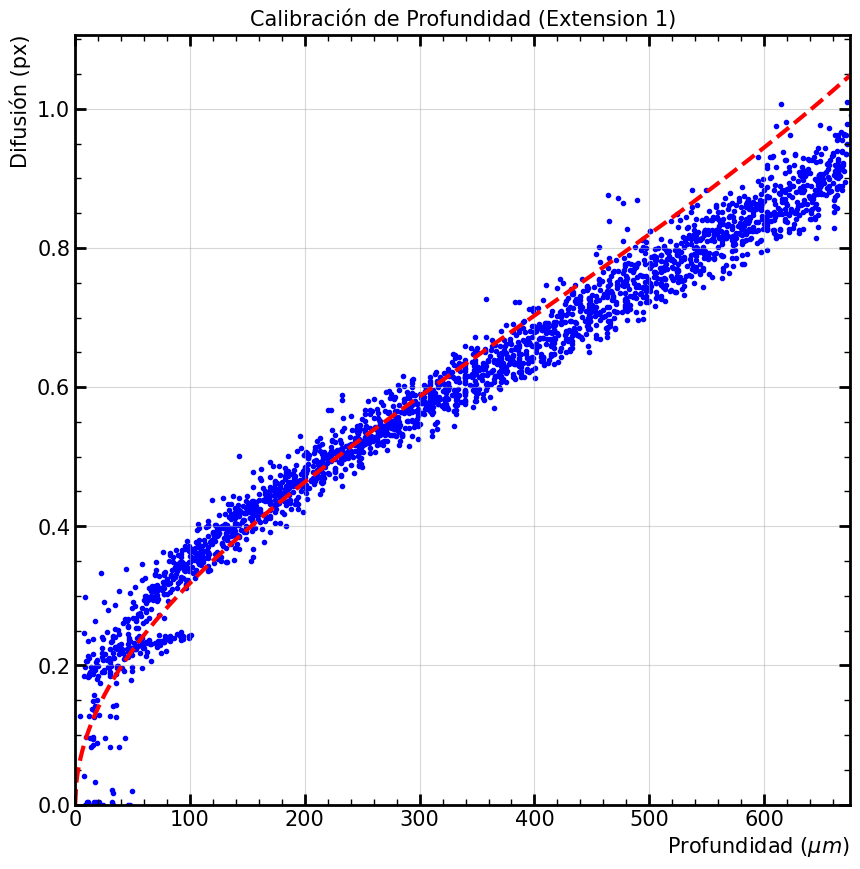

In [21]:
img_sigma = 0.0008  # KeV 
# print(img_sigma)
fig, axs_all = plt.subplots(figsize = [10,10])

# list_muonlabels = [256, 257, 258]

list_all_sigmas = []
list_all_deeps = []

for label_muon in list_muonlabels: 
    Delta_inicial = 1    # px
    Delta_final = 5     # px
    event = list_datamask[label_muon]
    size_x = event.shape[1]
    size_y = event.shape[0]

    # lines = 0
    Longitud_XY = size_y 
    Z_inicial = (Delta_inicial * CCD_depth) / (Longitud_XY - Delta_final)
    # print('Muon: ', label_muon, ', Shape (X, Y): ', event.shape[1], event.shape[0])

    list_fitsigmas = []
    if label_muon in list_muonlabels1:
        Delta_inicial = Delta_final
        Delta_final = Delta_inicial

    for lable_line in range(Delta_inicial, size_y - Delta_final):
        line = event[lable_line - 1:lable_line][0]
        Carga_renglon = line.sum()/ratio_KeVelec
        Mean_carga = np.mean(line)/ratio_KeVelec
        Longitud_linea = len(line)


        Mean_in  = 0
        var = 0
        carga_cuadrada = 0

        ### Se calcula el X promedio ##
        for pixel in range(0, Longitud_linea):
            if line[pixel]:
                element_pixel = (pixel * line[pixel]/ratio_KeVelec) / Carga_renglon
                Mean_in = Mean_in + element_pixel
            else:
                element_pixel = 0
            
            Mean_in = Mean_in + element_pixel

        ## Calcula la suma de las cargas al cuadrado ##
        for pixel in np.arange(0, Longitud_linea, 1):
            if line[pixel]:
                element_pixel = (line[pixel]/ratio_KeVelec)**2
            else:
                element_pixel = 0

            carga_cuadrada = carga_cuadrada + element_pixel 

        Mean_carga_cuadrada = carga_cuadrada/Longitud_linea

        ### Se calcula la varianza ##
        for pixel in np.arange(0, Longitud_linea, 1):
            if line[pixel]:
                element_pixel =(1 / (Longitud_linea - 1)) * (pixel - Mean_in)**2 * line[pixel]/ratio_KeVelec
                var = var + element_pixel  ### COreggir la varianza con otro estimados

        ### Se corrige la varianza con la carga ###
        var_true = var * (Mean_carga_cuadrada / (Mean_carga**2))
        # var_true = var / Carga_renglon

        ### Se calcula la sigma ###
        sigma_in = np.sqrt(var)
        # print(sigma_in)
        # sigma_in = np.sqrt(var_true)


        ##Se crea un arreglo para usarlo en el plot de los datos, y se realiza el juste ##
        list_xlabel = np.arange(0.5, len(line), 1)


        ## Ajuste gaussiano con ROOT ##
        fgaus2 = TF1("fgauss","gaus",  0,  len(line.flatten()), 3) # TF1("nombre", "funcion escrita como en root", min, max, #parametros)
        h3=TH1F("histogram", "Distribution of Line", len(line.flatten()) + 1, 0,  len(line.flatten()) )

        for index in range(0, len(line)):
            if line[index] != 0:
                # print(index, line[index])
                h3.SetBinContent( index + 1, line[index]/ratio_KeVelec)
                err = np.sqrt((img_sigma/ratio_KeVelec)**2 + line[index]/ratio_KeVelec)
                h3.SetBinError(index + 1,err )
                # h3.SetBinError(index + 1, img_sigma)
                # h3.SetBinError(index + 1, 0.001)
                #print(pixel_value)

        fgaus2.SetParameters(np.max(line),Mean_in,sigma_in) # Establecer parametros iniciales del fit, de manera visual es posible determinarlos como una primera aproximacion
        h3.Fit(fgaus2, "RQNL")

        fit_const = fgaus2.GetParameters()[0]
        fit_mean = fgaus2.GetParameters()[1]
        fit_sigma = fgaus2.GetParameters()[2]


        # fit_sigma = sigma_in
        # print('Sigma fit: ', fit_sigma)
        list_fitsigmas.append(fit_sigma)

        del h3

    list_deep = []
    list_xlabel_sigmas = np.linspace(Z_inicial, CCD_depth, len(list_fitsigmas))
    for deep in list_xlabel_sigmas:
        list_deep.append(deep)

    if label_muon in list_muonlabels1:
        # print('Gola', list_fitsigmas[0], list_fitsigmas[-1])
        list_fitsigmas.reverse()
        # print('Agios', list_fitsigmas[0], list_fitsigmas[-1], end='\n\n')
        
    for index in range(0, len(list_fitsigmas)):
        list_all_sigmas.append(list_fitsigmas[index])
        list_all_deeps.append(list_deep[index])

    # axs_all.scatter(list_deep, list_fitsigmas, marker='2', label = 'Muon: ' + str(label_muon))
del list_fitsigmas
del list_deep


fit_range = np.arange(0, 680)



axs_all.scatter(list_all_deeps, list_all_sigmas, marker='.', facecolor = 'b')

def diffution_curve(x, alpha, beta):
    return np.sqrt((alpha * np.log(1 - (beta * x))))

# popt_DM, _ = curve_fit(diffution_curve, list_all_deeps, list_all_sigmas, maxfev=100000, p0= [1, 1])
# dict_diffution_model = {'Alpha' : popt_DM[0], 'Beta' : popt_DM[1]}
# print('Alpha: ', dict_diffution_model['Alpha'], ' Beta: ', dict_diffution_model['Beta'])


# Label = r'$\sqrt{\alpha \ln(1 - \beta z)}$ fit $\alpha$:' + str(np.around(-211.9, 1)) + r' $\mu m^{2}$, $\beta$: ' + str(np.around(0.0012, 6)) + r' $\mu m^{-1}$'
axs_all.plot(fit_range, diffution_curve(fit_range, alpha=-211.9, beta=0.00102)/15, '--r', linewidth = 3)
# axs_all.plot(fit_range, diffution_curve(fit_range, -611, 0.00045)/15, '--r', linewidth = 3)

axs_all.set_title('Calibración de Profundidad (Extension 1)', size = 15)#, y=0.92)}
axs_all.set_ylabel(r'Difusión (px)')
axs_all.set_xlabel(r'Profundidad ($\mu m$)')
axs_all.set_ylim(0,)
axs_all.set_xlim(0, 675)
axs_all.legend()
axs_all.grid()
plt.show()

In [30]:
list_all_sigmas = []
list_all_deeps = []

for label_muon in list_muonlabels: 
    Delta_inicial = 1    # px
    Delta_final = 5     # px
    event = list_datamask[label_muon]
    size_x = event.shape[1]
    size_y = event.shape[0]

    # lines = 0
    Longitud_XY = size_y 
    Z_inicial = (Delta_inicial * CCD_depth) / (Longitud_XY - Delta_final)
    # print('Muon: ', label_muon, ', Shape (X, Y): ', event.shape[1], event.shape[0])

    list_fitsigmas = []
    if label_muon in list_muonlabels1:
        Delta_inicial = Delta_final
        Delta_final = Delta_inicial

    for lable_line in range(Delta_inicial, size_y - Delta_final):
        line = event[lable_line - 1:lable_line][0]
        Carga_renglon = line.sum()/ratio_KeVelec
        Mean_carga = np.mean(line)/ratio_KeVelec
        Longitud_linea = len(line)


        Mean_in  = 0
        var = 0
        carga_cuadrada = 0

        ### Se calcula el X promedio ##
        for pixel in range(0, Longitud_linea):
            if line[pixel]:
                element_pixel = (pixel * line[pixel]/ratio_KeVelec) / Carga_renglon
                Mean_in = Mean_in + element_pixel
            else:
                element_pixel = 0
            
            Mean_in = Mean_in + element_pixel

        ## Calcula la suma de las cargas al cuadrado ##
        for pixel in np.arange(0, Longitud_linea, 1):
            if line[pixel]:
                element_pixel = (line[pixel]/ratio_KeVelec)**2
            else:
                element_pixel = 0

            carga_cuadrada = carga_cuadrada + element_pixel 

        Mean_carga_cuadrada = carga_cuadrada/Longitud_linea

        ### Se calcula la varianza ##
        for pixel in np.arange(0, Longitud_linea, 1):
            if line[pixel]:
                element_pixel =(1 / (Longitud_linea - 1)) * (pixel - Mean_in)**2 * line[pixel]/ratio_KeVelec
                var = var + element_pixel  ### COreggir la varianza con otro estimados

        ### Se corrige la varianza con la carga ###
        # var_true = var * (Mean_carga_cuadrada / (Mean_carga**2))
        var_true = var / Carga_renglon

        ### Se calcula la sigma ###
        sigma_in = np.sqrt(var)
        # print(sigma_in)
        # sigma_in = np.sqrt(var_true)


        ##Se crea un arreglo para usarlo en el plot de los datos, y se realiza el juste ##
        list_xlabel = np.arange(0.5, len(line), 1)


        ## Ajuste gaussiano con ROOT ##
        fgaus2 = TF1("fgauss","gaus",  0,  len(line.flatten()), 3) # TF1("nombre", "funcion escrita como en root", min, max, #parametros)
        h3=TH1F("histogram", "Distribution of Line", len(line.flatten()) + 1, 0,  len(line.flatten()) )

        for index in range(0, len(line)):
            if line[index] != 0:
                # print(index, line[index])
                h3.SetBinContent( index + 1, line[index]/ratio_KeVelec)
                err = np.sqrt((img_sigma/ratio_KeVelec)**2 + line[index]/ratio_KeVelec)
                h3.SetBinError(index + 1,err )
                # h3.SetBinError(index + 1, img_sigma)
                # h3.SetBinError(index + 1, 0.001)
                #print(pixel_value)

        fgaus2.SetParameters(np.max(line),Mean_in,sigma_in) # Establecer parametros iniciales del fit, de manera visual es posible determinarlos como una primera aproximacion
        h3.Fit(fgaus2, "RQNL")

        fit_const = fgaus2.GetParameters()[0]
        fit_mean = fgaus2.GetParameters()[1]
        fit_sigma = fgaus2.GetParameters()[2]


        # fit_sigma = sigma_in
        # print('Sigma fit: ', fit_sigma)
        list_fitsigmas.append(fit_sigma)

        del h3

    list_deep = []
    list_xlabel_sigmas = np.linspace(Z_inicial, CCD_depth, len(list_fitsigmas))
    for deep in list_xlabel_sigmas:
        list_deep.append(deep)

    if label_muon in list_muonlabels1:
        # print('Gola', list_fitsigmas[0], list_fitsigmas[-1])
        list_fitsigmas.reverse()
        # print('Agios', list_fitsigmas[0], list_fitsigmas[-1], end='\n\n')

    for index in range(0, len(list_fitsigmas)):
        list_all_sigmas.append(list_fitsigmas[index])
        list_all_deeps.append(list_deep[index])

    # axs_all.scatter(list_deep, list_fitsigmas, marker='2', label = 'Muon: ' + str(label_muon))
del list_fitsigmas
del list_deep



# fit_range = np.arange(0, 900)
# axs_all.scatter(list_all_deeps, list_all_sigmas, marker='2')
new_list_allsig = []
new_list_alldeeps = []

for index in range(0, len(list_all_sigmas)):
    if list_all_sigmas[index]> 0.25 and list_all_deeps[index]>0:
        new_list_allsig.append(list_all_sigmas[index])
        new_list_alldeeps.append(list_all_deeps[index])
    else:
        continue

h_model = TGraph(len(new_list_allsig), np.array(new_list_alldeeps),np.array(new_list_allsig))
h_model.SetMarkerStyle(2) # Set marker style (e.g., solid circle)
h_model.SetTitle("Diffution Model (Vertical Muons)")
h_model.GetXaxis().SetTitle("Depth (#mu m)")
h_model.GetYaxis().SetTitle("Spread (px)")
h_model.SetStats(0)
h_model.GetXaxis().SetRangeUser(0, 680)
h_model.GetYaxis().SetRangeUser(0, 1.2)

h_modelall = TGraph(len(list_all_sigmas), np.array(list_all_deeps),np.array(list_all_sigmas))
h_modelall.SetMarkerStyle(2) # Set marker style (e.g., solid circle)
h_modelall.SetMarkerColor(15)
h_modelall.SetTitle("Diffution Model (Vertical Muons)")
h_modelall.GetXaxis().SetTitle("Depth (#mu m)")
h_modelall.GetYaxis().SetTitle("Spread (px)")
# h_modelall.SetStats(0)

Range_fit = [0, 680]
diff_curve = TF1("diff_curve", "sqrt(([0] * log(1 - [1]*x)))/15", Range_fit[0], Range_fit[1], 2) #np.sqrt(np.abs(alpha * np.log(1 - (beta * z))))
diff_curveCONNIE = TF1("diff_curve", "sqrt(([0] * log(1 - [1]*x)))/15", 0, Range_fit[1], 2)
diff_curveCONNIE.SetParameters(-211.9, 0.00102)
diff_curveCONNIE.SetLineColor(6)

diff_curve.SetParameters(-800, 0.00014) # Establecer parametros iniciales del fit, de manera visual es posible determinarlos como una primera aproximacion
h_model.Fit(diff_curve, "RNQ")



fit_alpha = diff_curve.GetParameters()[0]
fit_beta = diff_curve.GetParameters()[1]
chi2 = diff_curve.GetChisquare()
ndf = diff_curve.GetNDF()
prob = diff_curve.GetProb()

fit_alpha_err = diff_curve.GetParErrors()[0]
fit_beta_err = diff_curve.GetParErrors()[1]

diff_curveTrue = TF1("diff_curve", "sqrt(([0] * log(1 - [1]*x)))/15", 0, 680, 2)
diff_curveTrue.SetParameters(fit_alpha, fit_beta)

print('Alpha: ', fit_alpha, '+- ', fit_alpha_err) 
print('Beta: ', fit_beta,  '+- ', fit_beta_err)
print('Chi2/ndf: ', chi2, '/', ndf)
print('Prob: ', prob)

c3=TCanvas("","", 1000, 600)
h_modelall.Draw("AP same")
h_model.Draw("P same")
diff_curveTrue.Draw("same")
# diff_curve.Draw("same")
diff_curveCONNIE.Draw("same")
c3.Draw()

leg = TLegend(0.1,0.7,0.48,0.9)
leg.AddEntry(diff_curveTrue, r"\sqrt{\alpha \log(1 - \beta z)} fit: \alpha= " + str(np.around(fit_alpha, 3)) + r" \mu m^2, \beta= " + str(np.around(fit_beta, 5)) + " \mu m^{-1}", "L")
leg.AddEntry(diff_curveCONNIE, r"CONNIE fit:  \alpha = -211.9 \mu m^2, \beta= 0.00102 \mu m^{-1}", "L")
leg.Draw()

Alpha:  -635.9168204470537 +-  35.872820361092515
Beta:  0.00037522522232047553 +-  1.9142922262435716e-05
Chi2/ndf:  2.0616524374118046 / 2227
Prob:  1.0


In [31]:
from array import array

spread_array = array('f', [-9999])
deep_array = array('f', [-9999])

location_file = './'
# file_root_name = 'tree_DiffusionMod_Vert_90deg_elec.root'
file_root_name = 'tree_DiffusionMod_Vert_90deg_elecALL.root'
file = TFile.Open(location_file  + file_root_name, "RECREATE")
tree = TTree('tree', 'tree')

tree.Branch('sprd', spread_array, 'sprd/F')
tree.Branch('deep', deep_array, 'deep/F')

for i in range(0, len(list_all_sigmas)):
    spread_array[0] = list_all_sigmas[i]
    deep_array[0] = list_all_deeps[i]
    
    tree.Fill()

tree.Write()
file.Close()

### Muones horizontales

#### DataFrame y visualización

In [32]:
### Se crea el dataframe y se selecciona un rango de datos ###
Ext = 1
DF_muons, list_datamask = DataFrame_muons(data_histogram, extension=Ext)
# display(DF_muons[450:500])
list_newmatrix = []
list_indexs =[]
#
# range_in_phi = DF_muons[DF_muons['Phi (Deg)'].between(0, 5)]    # Horizontales derecha
# range_in_phi = DF_muons[DF_muons['Phi (Deg)'].between(355, 360)]

range_in_phi = DF_muons[DF_muons['Phi (Deg)'].between(175, 185)] # Left muons

for index in range_in_phi.index:
    # print(index)
    list_newmatrix.append(list_datamask[index])
    list_indexs.append(index)

print(list_indexs)
list_phi_ext1 = data_histogram['extension_' + str(Ext)]['phi']
list_mask_rot = []

list_listsnxny = []

for index in list_indexs[:]:
    datamask = list_datamask[index]
    ylen, xlen = datamask.shape
    list_nxny = []

    data_mask_zeros = np.empty((ylen + 90, xlen+50))
    data_mask_zeros[:] = 0
    ylen_zeros, xlen_zeros = data_mask_zeros.shape
    # print(data_mask_zeros.shape)
    
    ### Angle rot ##
    phi_rot = np.pi/2 - list_phi_ext1[index]
    # print(phi_rot, phi_rot + list_phi_ext1[index])

    # print('shape original: ', xlen, ylen)
    # print('shape zeros: ', xlen_zeros, ylen_zeros)

    # for y_bin in range(0, ylen):
    #     for x_bin in range(0, xlen):
    #         if datamask[y_bin][x_bin] != 0:
    #             nx, ny = pixel_rot(x_bin=x_bin, x0=0, y_bin=y_bin, y0=0, theta= phi_rot)
    #             list_nxny.append((nx + 200, ny))
    #             # print(nx, ny)
    #             data_mask_zeros[ny][nx+200] = datamask[y_bin][x_bin]

    # list_listsnxny.append(list_nxny)
    # label_img, nlabels_img = sk.measure.label(data_mask_zeros > 0, connectivity=2, return_num=True)
    # loc = nd.find_objects(label_img == 1)[0]
    # mask_rot = np.invert(label_img==1)
    # # data_mask_rot = ma.masked_array(data_mask_zeros, mask_rot)
    # data_mask_rot = ma.masked_array(data_mask_zeros[loc[0].start:loc[0].stop, loc[1].start:loc[1].stop], mask_rot[loc[0].start:loc[0].stop, loc[1].start:loc[1].stop])

    # list_mask_rot.append(data_mask_rot)
    # print('Shape rot: ', data_mask_rot.shape[1], data_mask_rot.shape[0])
    
    # plt.imshow(data_mask_rot)
    # plt.show()

# print(list_mask_rot)
#     

[2, 4, 32, 34, 69, 104, 125, 143, 268, 280, 292, 296, 328, 339, 353, 376, 385, 409, 414, 444, 468, 546, 581, 591, 603, 638, 648, 651, 660, 664, 680, 707, 790, 812, 821, 900, 942, 953, 964, 984, 1016, 1030, 1060, 1092, 1101, 1112, 1135, 1174, 1194, 1199, 1230, 1249, 1316, 1347, 1378, 1432, 1494, 1509, 1577, 1665, 1689, 1699, 1748, 1752, 1797, 1814, 1839, 1855, 1895, 1920, 1939, 1952, 1953, 1987, 2025, 2035, 2048, 2059, 2060, 2081, 2086, 2087, 2124, 2151, 2176, 2189, 2190, 2236, 2243, 2260, 2279, 2285, 2295, 2297, 2331, 2344, 2349, 2353, 2390, 2467, 2468, 2493, 2494, 2495, 2538, 2539, 2543, 2566, 2587, 2640, 2676, 2718, 2732, 2766, 2770, 2785, 2806, 2850, 2853, 2908, 2915, 2952, 3000, 3046, 3079, 3087, 3114, 3208, 3226, 3229, 3299, 3330, 3344, 3452, 3464, 3479, 3486, 3532, 3551, 3565, 3572, 3630, 3632, 3662, 3663, 3665, 3670, 3749, 3819, 3844, 3976, 4020, 4043, 4055, 4164, 4236, 4382, 4457, 4505, 4691, 4790, 4840, 4859, 5004, 5012, 5017, 5050, 5070, 5160, 5256, 5291, 5547, 5580, 5650, 56

,Solidity,Elipticity,Theta (Deg),Phi (Deg),Charge (KeV),l (cm),dEdL (KeV/cm)
Muon ID,,,,,,,
201,0.81016,0.895325,52.321456,3.749315,1.356056,0.110433,12.279457


Shape: (9, 59)


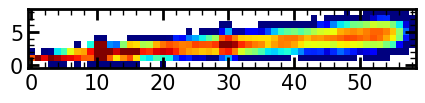

In [33]:
n_label = 201 #  [201, 375, 520, 762, 1020, 1152, 1413, 1435, 1573, 1650, 1885
display(DF_muons.iloc[[n_label]])

print("Shape: {}".format(list_datamask[n_label].shape))
figure , axs = plt.subplots(1,1,figsize=[5,5])
# axs.imshow(list_mask_rot[n_label],  cmap = ColorMap, norm=Norm)  
axs.imshow(list_datamask[n_label],  cmap = ColorMap, norm=Norm)
plt.show()


Numper of rows:  9
Long of line:  2


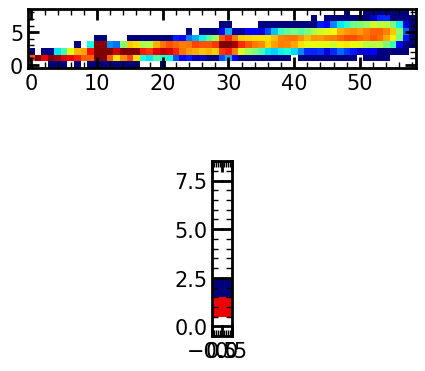

In [34]:
figure , axs = plt.subplots(2,1,figsize=[5,5])

label_muon = n_label
label_line = 2 # [2, 292, 376, 651, 1101, 1174, 1194, 1199, 
muon = list_datamask[label_muon]
print('Numper of rows: ', muon.shape[0])
line = muon[:, label_line: label_line + 1]
# line = list_mask_rot[label_muon][label_line - 1:label_line][0]

n_longline = 0
for pixel in line:
    if pixel[0] != 0:
        # print(pixel)
        n_longline += 1

print('Long of line: ', n_longline)

# axs[0].imshow(list_mask_rot[label_muon], norm = Norm)
# axs[1].imshow(list_mask_rot[label_muon][label_line - 1:label_line], norm = Norm)

axs[0].imshow(muon, cmap=ColorMap, norm = Norm)
axs[1].imshow(muon[:, label_line: label_line + 1], cmap=ColorMap, norm = Norm)
plt.show()

In [35]:
list_index_long_muons = []
extension = 1

for index in range(0, len(list_newmatrix)):
    size_x = list_newmatrix[index].shape[1]
    size_y = list_newmatrix[index].shape[0]
    if size_x > 50:
        # print(size_x, size_y)
        list_index_long_muons.append(list_indexs[index])

# print(list_index_long_muons)+
print('Muones largos detectados: ', len(list_index_long_muons))
print('Indices: ', list_index_long_muons)

Muones largos detectados:  51
Indices:  [143, 268, 409, 581, 900, 953, 1092, 1199, 1230, 1814, 1839, 1855, 1895, 1939, 2025, 2048, 2081, 2189, 2260, 2331, 2344, 2353, 2467, 2493, 2566, 2908, 2915, 2952, 3079, 3114, 3330, 3464, 3976, 4020, 4164, 4505, 4840, 4859, 5547, 5650, 5684, 6251, 6393, 7053, 7768, 7909, 8058, 8203, 8243, 8455, 8528]


#### Perfil energético

52.32145587318327
Number of rows:  5


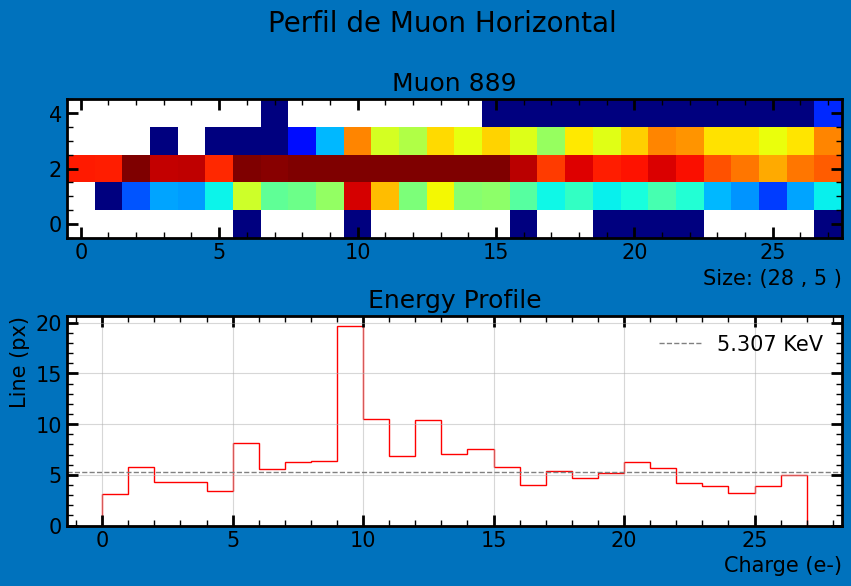

In [36]:
muon_label = 889  # Se coloca directamente el label del evento
thet = DF_muons.iloc[[n_label]]['Theta (Deg)'].values[0]
print(thet)

Delta_inicial = 0
Delta_final = 0
extension = 1

fig, axs = plt.subplots(ncols=1, nrows=2, figsize = [10,6], facecolor = [0, 0.4470, 0.7410])
fig.suptitle('Perfil de Muon Horizontal', y = 0.97, size = 20)
event = list_datamask[muon_label]
# plt.imshow(event)

size_x = event.shape[1] # tamaño en x
size_y = event.shape[0] # tamaño en y
# print(event.sum())

print('Number of rows: ', event.shape[0])
charge_horizontalMuon = []
for index in range(1, size_x):
    line = event[:, index: index + 1]
    charge = line.sum()
    charge_horizontalMuon.append(charge)

        
# cmap = 'plasma'
axs[0].imshow(event, cmap = ColorMap, norm = Norm)#, origin='upper')
axs[0].set_title('Muon ' + str(muon_label))
axs[0].set_xlabel('Size: (' + str(size_x) + ' , ' + str(size_y) + ' )')
# x0bar = fig.colorbar(x0, ax=axs[0])

en_cor = 4.2 /np.sin(np.radians(thet))
axs[1].stairs(charge_horizontalMuon, range(0,len(charge_horizontalMuon)+1),  orientation='vertical', color = 'r')#,  hatch = '////')
axs[1].axhline(en_cor, 0, size_x+2, linestyle='--', color='gray', label = str(np.around(en_cor, 3)) +  ' KeV')
# axs[1].vlines(x = mean_charge, ymin = 0, ymax = len(event) - 1, color = 'k', label = 'Mean Charge \n' + str(mean_charge))

# axs[1].set_ylim(0, size_x)
# axs[1].set_xlim(0, 4000)


# axs[1].set_xlabel('Charge (KeV)')
axs[1].set_xlabel('Charge (e-)')
axs[1].set_ylabel('Line (px)')
# axs[1].set_ylim(0,len(event) - 1 )
axs[1].set_title('Energy Profile')
axs[1].legend()
axs[1].grid()
plt.show()

#### Modelo Difusión

In [37]:
CCD_depth = 680 # micras
Delta_inicial = 3    # px
Delta_final = 6     # px
Bins = 50

extension = 1
label_muon = 201
lable_line = 50
img_sigma = 0.0003  # KeV 
# print(img_sigma)

## Se checa si el muon tiene la orientación correcta
event = list_datamask[label_muon]
size_x = event.shape[1]
size_y = event.shape[0]

# lines = 0
Longitud_XY = size_x 
Longitud_linea = size_y

Z_inicial = (Delta_inicial * CCD_depth) / (Longitud_XY - Delta_final)


line = event[:, lable_line: lable_line + 1]
Carga_renglon = line.sum()/ratio_KeVelec
Mean_carga = np.mean(line)/ratio_KeVelec
# print(Carga_renglon, Mean_carga, len(line))


Mean_in  = 0
var = 0
carga_cuadrada = 0
pixels_with_charge = 0

### Se calcula el X promedio ##
for pixel in range(0, Longitud_linea, 1):
    if line[pixel][0]:
        pixels_with_charge+=1
        element_pixel = (pixel * line[pixel][0]/ratio_KeVelec) / Carga_renglon
        Mean_in = Mean_in + element_pixel
    else:
        element_pixel = 0
    
    Mean_in = Mean_in + element_pixel

## Calcula la suma de las cargas al cuadrado ##
for pixel in range(0, Longitud_linea, 1):
    if line[pixel][0]:
        # print(line[pixel])
        element_pixel = (line[pixel][0]/ratio_KeVelec)**2
    else:
        element_pixel = 0

    carga_cuadrada = carga_cuadrada + element_pixel 

Mean_carga_cuadrada = carga_cuadrada/Longitud_linea

### Se calcula la varianza ##
for pixel in range(0, Longitud_linea, 1):
    element_pixel =(1 / (Longitud_linea - 1)) * (pixel - Mean_in)**2
    var = var + element_pixel  ### COreggir la varianza con otro estimados

### Se corrige la varianza con la carga ###
var_true = var * (Mean_carga_cuadrada / (Mean_carga**2))

### Se calcula la sigma ###
sigma_in = np.sqrt(var)
# sigma_in = np.sqrt(var_true)


##Se crea un arreglo para usarlo en el plot de los datos, y se realiza el juste ##
list_xlabel = np.arange(0.5, len(line), 1)
print('Lonitud de la linea: ', len(line))

## Ajuste gaussiano con ROOT ##
fgaus2 = TF1("fgauss","gaus",  0,  len(line), 3) # TF1("nombre", "funcion escrita como en root", min, max, #parametros)
h3=TH1F("histogram", "Line Distribution: {}".format(lable_line), len(line) + 1, 0,  len(line) )
h3.SetStats(0)
h3.GetXaxis().SetTitle("Position (px)")
h3.GetYaxis().SetTitle("Charge (e-)")
# h3.GetYaxis().SetRangeUser(0, 140)

for index in range(0, len(line)):
    if line[index][0] != 0:
        # print(index, line[index])
        h3.SetBinContent( index + 1, line[index][0]/ratio_KeVelec)
        err = np.sqrt(img_sigma**2 + line[index][0]/ratio_KeVelec)
        h3.SetBinError(index + 1, err)
        # h3.SetBinError(index + 1, 0.001)
        #print(pixel_value)

fgaus2.SetParameters(np.max(line),Mean_in,sigma_in) # Establecer parametros iniciales del fit, de manera visual es posible determinarlos como una primera aproximacion
h3.Fit(fgaus2, "RQNL")

fit_const = fgaus2.GetParameters()[0]
fit_mean = fgaus2.GetParameters()[1]
fit_sigma = fgaus2.GetParameters()[2]
chisquare = fgaus2.GetChisquare()
NDFval = fgaus2.GetNDF()


print('Sigma fit: ', fit_sigma, end='\n\n')

leg = TLegend(0.1,0.7,0.48,0.9)
leg.AddEntry(fgaus2, r"Gaussian Fit:", "L")
leg.AddEntry(0, r"\mu= {} #pm {} px".format(np.around(fit_mean, 3), np.around(fgaus2.GetParErrors()[1], 3)), "")
# leg.AddEntry(0, "Some text", "");
leg.AddEntry(0, r" \sigma= {} #pm {} px".format(np.around(fit_sigma, 3), np.around(fgaus2.GetParErrors()[2], 3)), "")
leg.AddEntry(0, r" #chi^2/NDF= {} / {}".format(np.around(chisquare, 3), np.around(NDFval, 3)), "")
leg.AddEntry(h3, r" Pixels with charge: {} ".format(pixels_with_charge), "L")

c3=TCanvas()
c3.SetGrid()

h3.Draw()
leg.Draw("same")
c3.Draw()
fgaus2.Draw("same")

Lonitud de la linea:  9
Sigma fit:  0.894526426000719



Total Muons: 37


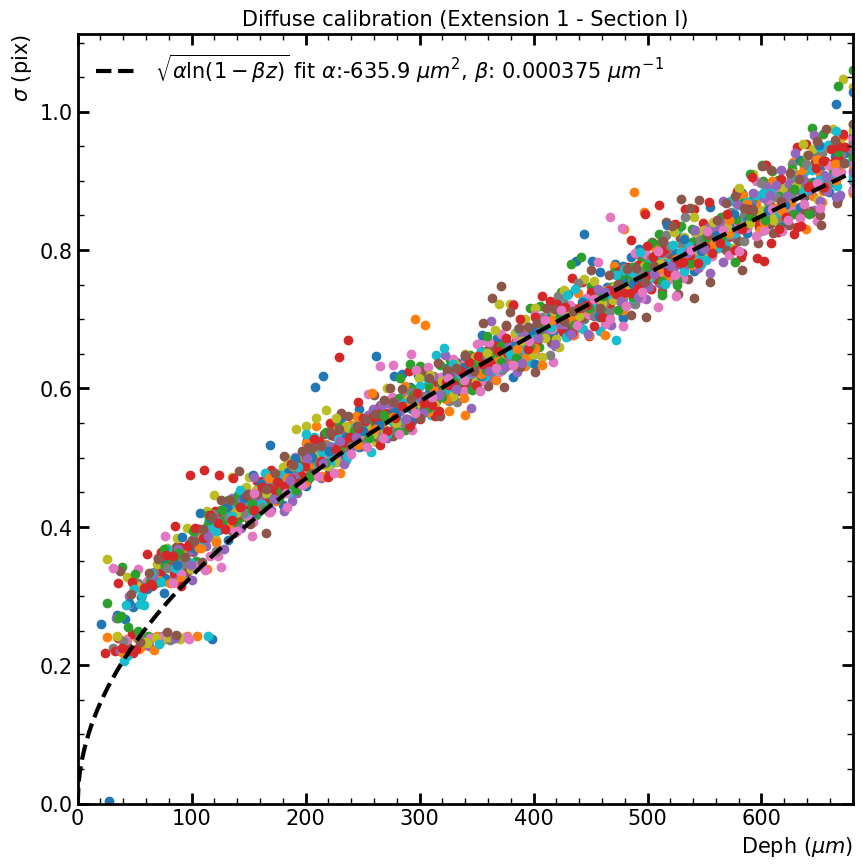

Warning in <TROOT::Append>: Replacing existing TH1: histogram (Potential memory leak).


In [38]:
CCD_depth = 680 # micras
Delta_inicial = 3    # px
Delta_final = 6     # px
Bins = 50

extension = 1
img_sigma = 0.0003  # KeV 
# print(img_sigma)
fig, axs_all = plt.subplots(figsize = [10,10])

# Data for phi between 0 to 5 deg
# 520, 1020,1435, 1650, 3544, 3963, 4661, 5567, 5752, 5808, 5877, 6767, 7003,

# Data for phi between 355 to 360 deg
# 1247, 4588, 4732, 5834, 6028, 6125, 6910, 7566, 8329, 8363

# Data for phi between 175 to 185 
# 581, 1092, 1839, 2048, 2189, 2331, 2467, 2566, 2952, 3079, 3464, 3976, 4840, 4859

# 581, 1092, 1839, 2048, 2189, 2331, 2467, 2566, 2952, 3079, 3464, 3976, 4840, 4859
list_muonlabels0 = [520, 1020,1435, 1650, 3544, 3963, 4661, 5567, 5752, 5808, 5877, 6767, 7003,] # Phi 0 to 5 deg
list_muonlabels1 = [1247, 4588, 4732, 5834, 6028, 6125, 6910, 7566, 8329, 8363] # Phi 355 to 360
list_muonlabels2 = [581, 1092, 1839, 2048, 2189, 2331, 2467, 2566, 2952, 3079, 3464, 3976, 4840, 4859]  # Phi 175 to 185

# print(list_muonlabels0 +  list_muonlabels1)
list_muonlabels = list_muonlabels0  +  list_muonlabels1  +  list_muonlabels2 
# list_muonlabels = list_muonlabels0  +  list_muonlabels1 
# list_muonlabels = list_muonlabels2

print('Total Muons: {}'.format(len(list_muonlabels)))
for label_muon in list_muonlabels: 
    event = list_datamask[label_muon]
    size_x = event.shape[1]
    size_y = event.shape[0]

    # lines = 0
    Longitud_XY = size_x 
    Z_inicial = (Delta_inicial * CCD_depth) / (Longitud_XY - Delta_final)
    # print('Muon: ', label_muon, ', Shape (X, Y): ', event.shape[1], event.shape[0])

    list_fitsigmas = []
    if label_muon in list_muonlabels2:
        Delta_inicial = Delta_final
        Delta_final = Delta_inicial


    for lable_line in range(Delta_inicial, size_x - Delta_final):
        # print(label_line)
        line = event[:, lable_line: lable_line + 1]
        Carga_renglon = line.sum()/ratio_KeVelec
        Mean_carga = np.mean(line)/ratio_KeVelec
        Longitud_linea = len(line)

        Mean_in  = 0
        var = 0
        carga_cuadrada = 0

        ### Se calcula el X promedio ##
        for pixel in range(0, Longitud_linea):
            if line[pixel][0]:
                element_pixel = (pixel * line[pixel][0]/ratio_KeVelec) / Carga_renglon
                Mean_in = Mean_in + element_pixel
            else:
                element_pixel = 0
            
            Mean_in = Mean_in + element_pixel

        ## Calcula la suma de las cargas al cuadrado ##
        for pixel in range(0, Longitud_linea, 1):
            if line[pixel][0]:
                element_pixel = (line[pixel][0]/ratio_KeVelec)**2
            else:
                element_pixel = 0

            carga_cuadrada = carga_cuadrada + element_pixel 

        Mean_carga_cuadrada = carga_cuadrada/Longitud_linea

        ### Se calcula la varianza ##
        for pixel in range(0, Longitud_linea, 1):
            if line[pixel][0]:
                element_pixel =(1 / (Longitud_linea - 1)) * (pixel - Mean_in)**2 * line[pixel][0]/ratio_KeVelec
                # element_pixel =(1 / (Longitud_linea - 1)) * (pixel - Mean_in)**2
                var = var + element_pixel  ### COreggir la varianza con otro estimados

        ### Se corrige la varianza con la carga ###
        var_true = var * (Mean_carga_cuadrada / (Mean_carga**2))
        # var_true = var / Carga_renglon

        ### Se calcula la sigma ###
        sigma_in = np.sqrt(var_true)
        # print(sigma_in)
        # sigma_in = np.sqrt(var_true)


        ##Se crea un arreglo para usarlo en el plot de los datos, y se realiza el juste ##
        list_xlabel = np.arange(0.5, len(line), 1)


        ## Ajuste gaussiano con ROOT ##
        fgaus2 = TF1("fgauss","gaus",  0,  len(line), 3) # TF1("nombre", "funcion escrita como en root", min, max, #parametros)
        h3=TH1F("histogram", "Distribution of Line", len(line) + 1, 0,  len(line) )

        for index in range(0, len(line)):
            if line[index][0] != 0:
                # print(index, line[index])
                h3.SetBinContent( index + 1, line[index][0]/ratio_KeVelec)
                err = np.sqrt(img_sigma**2 + line[index][0]/ratio_KeVelec)
                h3.SetBinError(index + 1, err)
                # h3.SetBinError(index + 1, 0.001)
                #print(pixel_value)

        fgaus2.SetParameters(np.max(line),Mean_in,sigma_in) # Establecer parametros iniciales del fit, de manera visual es posible determinarlos como una primera aproximacion
        h3.Fit(fgaus2, "RQNL")

        fit_const = fgaus2.GetParameters()[0]
        fit_mean = fgaus2.GetParameters()[1]
        fit_sigma = fgaus2.GetParameters()[2]


        # fit_sigma = sigma_in
        # print('Sigma fit: ', fit_sigma)
        list_fitsigmas.append(fit_sigma)

        del h3

    list_deep = []
    list_xlabel_sigmas = np.linspace(Z_inicial, CCD_depth, len(list_fitsigmas))
    for deep in list_xlabel_sigmas:
        list_deep.append(deep)

    if label_muon in list_muonlabels2:
        list_fitsigmas.reverse()

    # axs_all.scatter(list_deep, list_fitsigmas, label = 'Muon: ' + str(label_muon))
    axs_all.scatter(list_deep, list_fitsigmas)


def diffution_curve(z, alpha, beta):
    return np.sqrt((alpha * np.log(1 - (beta * z))))

fit_range = np.arange(0, 680)
# fit_alpha, fit_beta = -348.2, 0.000702
Label = r'$\sqrt{\alpha \ln(1 - \beta z)}$ fit $\alpha$:' + str(np.around(fit_alpha, 1)) + r' $\mu m^{2}$, $\beta$: ' + str(np.around(fit_beta, 6)) + r' $\mu m^{-1}$'

# axs_all.plot(fit_range, diffution_curve(fit_range, alpha=-200, beta=0.001) / 15, '--r', linewidth = 3)
axs_all.plot(fit_range, diffution_curve(fit_range, alpha=fit_alpha, beta=fit_beta)/15, '--k', linewidth = 3, label= Label)
# axs_all.plot(fit_range, diffution_curve(fit_range, alpha=-292.4325743170209, beta=3.990904646095944e-06), '--c', linewidth = 2, label='Fit CONNIE')

axs_all.set_title('Diffuse calibration (Extension 1 - Section I)', size = 15)#, y=0.92)}
axs_all.set_ylabel(r'$\sigma$ (pix)')
axs_all.set_xlabel(r'Deph ($\mu m$)')
axs_all.set_ylim(0, )
axs_all.set_xlim(0, 680)
axs_all.legend()
axs_all.grid
plt.show()

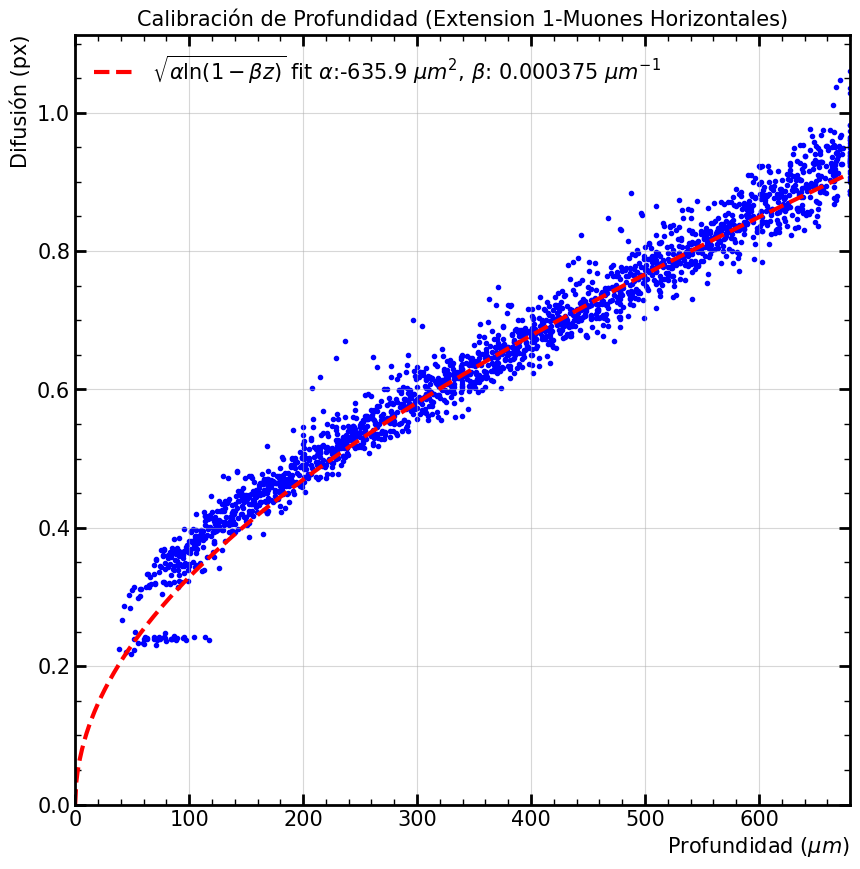

In [39]:
img_sigma = 0.0003  # KeV 
# print(img_sigma)
fig, axs_all = plt.subplots(figsize = [10,10])

# list_muonlabels = [256, 257, 258]

list_all_sigmas = []
list_all_deeps = []

for label_muon in list_muonlabels: 
    event = list_datamask[label_muon]
    size_x = event.shape[1]
    size_y = event.shape[0]

    # lines = 0
    Longitud_XY = size_x
    Z_inicial = (Delta_inicial * CCD_depth) / (Longitud_XY - Delta_final)
    # print('Muon: ', label_muon, ', Shape (X, Y): ', event.shape[1], event.shape[0])

    list_fitsigmas = []
    if label_muon in list_muonlabels2:
        Delta_inicial = Delta_final
        Delta_final = Delta_inicial

    for lable_line in range(Delta_inicial, size_x - Delta_final):
        line = event[:, lable_line: lable_line + 1]
        Carga_renglon = line.sum()/ratio_KeVelec
        Mean_carga = np.mean(line)/ratio_KeVelec
        Longitud_linea = len(line)


        Mean_in  = 0
        var = 0
        carga_cuadrada = 0

        ### Se calcula el X promedio ##
        for pixel in range(0, Longitud_linea):
            if line[pixel][0]:
                element_pixel = (pixel * line[pixel][0]/ratio_KeVelec) / Carga_renglon
                Mean_in = Mean_in + element_pixel
            else:
                element_pixel = 0
            
            Mean_in = Mean_in + element_pixel

        ## Calcula la suma de las cargas al cuadrado ##
        for pixel in range(0, Longitud_linea, 1):
            if line[pixel][0]:
                element_pixel = (line[pixel][0]/ratio_KeVelec)**2
            else:
                element_pixel = 0

            carga_cuadrada = carga_cuadrada + element_pixel 

        Mean_carga_cuadrada = carga_cuadrada/Longitud_linea

        ### Se calcula la varianza ##
        for pixel in range(0, Longitud_linea, 1):
            if line[pixel][0]:
                element_pixel =(1 / (Longitud_linea - 1)) * (pixel - Mean_in)**2 * line[pixel][0]/ratio_KeVelec
                var = var + element_pixel  ### COreggir la varianza con otro estimados

        ### Se corrige la varianza con la carga ###
        # var_true = var * (Mean_carga_cuadrada / (Mean_carga**2))
        var_true = var / Carga_renglon

        ### Se calcula la sigma ###
        sigma_in = np.sqrt(var)
        # print(sigma_in)
        # sigma_in = np.sqrt(var_true)


        ##Se crea un arreglo para usarlo en el plot de los datos, y se realiza el juste ##
        list_xlabel = np.arange(0.5, len(line), 1)


        ## Ajuste gaussiano con ROOT ##
        fgaus2 = TF1("fgauss","gaus",  0,  len(line), 3) # TF1("nombre", "funcion escrita como en root", min, max, #parametros)
        h3=TH1F("histogram", "Distribution of Line", len(line) + 1, 0,  len(line) )

        for index in range(0, len(line)):
            if line[index][0] != 0:
                # print(index, line[index])
                h3.SetBinContent( index + 1, line[index][0]/ratio_KeVelec)
                err = np.sqrt(img_sigma**2 + line[index][0]/ratio_KeVelec)
                h3.SetBinError(index + 1, err)
                # h3.SetBinError(index + 1, 0.001)
                #print(pixel_value)

        fgaus2.SetParameters(np.max(line),Mean_in,sigma_in) # Establecer parametros iniciales del fit, de manera visual es posible determinarlos como una primera aproximacion
        h3.Fit(fgaus2, "RQNL")

        fit_const = fgaus2.GetParameters()[0]
        fit_mean = fgaus2.GetParameters()[1]
        fit_sigma = fgaus2.GetParameters()[2]


        # fit_sigma = sigma_in
        # print('Sigma fit: ', fit_sigma)
        list_fitsigmas.append(fit_sigma)

        del h3

    list_deep = []
    list_xlabel_sigmas = np.linspace(Z_inicial, CCD_depth, len(list_fitsigmas))
    for deep in list_xlabel_sigmas:
        list_deep.append(deep)

    # if label_muon in (143, 302, 321, 362, 383, 385, 404, 434, 550, 793, 864, 929, 1090, 1091):
    #     # print('Gola', list_fitsigmas[0], list_fitsigmas[-1])
    #     list_fitsigmas.reverse()
    #     # print('Agios', list_fitsigmas[0], list_fitsigmas[-1], end='\n\n')
    if label_muon in list_muonlabels2:
        list_fitsigmas.reverse()
        
    for index in range(0, len(list_fitsigmas)):
        list_all_sigmas.append(list_fitsigmas[index])
        list_all_deeps.append(list_deep[index])

    # axs_all.scatter(list_deep, list_fitsigmas, marker='2', label = 'Muon: ' + str(label_muon))
del list_fitsigmas
del list_deep


fit_range = np.arange(0, 680)

axs_all.scatter(list_all_deeps, list_all_sigmas, marker='.', facecolor = 'b')

def diffution_curve(x, alpha, beta):
    return np.sqrt((alpha * np.log(1 - (beta * x))))

# popt_DM, _ = curve_fit(diffution_curve, list_all_deeps, list_all_sigmas, maxfev=100000, p0= [1, 1])
# dict_diffution_model = {'Alpha' : popt_DM[0], 'Beta' : popt_DM[1]}
# print('Alpha: ', dict_diffution_model['Alpha'], ' Beta: ', dict_diffution_model['Beta'])



axs_all.plot(fit_range, diffution_curve(fit_range, alpha=fit_alpha, beta=fit_beta)/15, '--r', linewidth = 3, label= Label)
# axs_all.plot(fit_range, diffution_curve(fit_range, -611, 0.00045)/15, '--r', linewidth = 3)

axs_all.set_title('Calibración de Profundidad (Extension 1-Muones Horizontales)', size = 15)#, y=0.92)}
axs_all.set_ylabel(r'Difusión (px)')
axs_all.set_xlabel(r'Profundidad ($\mu m$)')
axs_all.set_ylim(0,)
axs_all.set_xlim(0, 680)
axs_all.legend()
axs_all.grid()
plt.show()

In [44]:
list_all_sigmas = []
list_all_deeps = []

for label_muon in list_muonlabels: 
    event = list_datamask[label_muon]
    size_x = event.shape[1]
    size_y = event.shape[0]

    # lines = 0
    Longitud_XY = size_x
    Z_inicial = (Delta_inicial * CCD_depth) / (Longitud_XY - Delta_final)
    # print('Muon: ', label_muon, ', Shape (X, Y): ', event.shape[1], event.shape[0])

    list_fitsigmas = []
    if label_muon in list_muonlabels2:
        Delta_inicial = Delta_final
        Delta_final = Delta_inicial

    for lable_line in range(Delta_inicial, size_x - Delta_final):
        line = event[:, lable_line: lable_line + 1]
        Carga_renglon = line.sum()/ratio_KeVelec
        Mean_carga = np.mean(line)/ratio_KeVelec
        Longitud_linea = len(line)


        Mean_in  = 0
        var = 0
        carga_cuadrada = 0

        ### Se calcula el X promedio ##
        for pixel in range(0, Longitud_linea):
            if line[pixel][0]:
                element_pixel = (pixel * line[pixel][0]/ratio_KeVelec) / Carga_renglon
                Mean_in = Mean_in + element_pixel
            else:
                element_pixel = 0
            
            Mean_in = Mean_in + element_pixel

        ## Calcula la suma de las cargas al cuadrado ##
        for pixel in range(0, Longitud_linea, 1):
            if line[pixel][0]:
                element_pixel = (line[pixel][0]/ratio_KeVelec)**2
            else:
                element_pixel = 0

            carga_cuadrada = carga_cuadrada + element_pixel 

        Mean_carga_cuadrada = carga_cuadrada/Longitud_linea

        ### Se calcula la varianza ##
        for pixel in range(0, Longitud_linea, 1):
            if line[pixel][0]:
                element_pixel =(1 / (Longitud_linea - 1)) * (pixel - Mean_in)**2 * line[pixel][0]/ratio_KeVelec
                var = var + element_pixel  ### COreggir la varianza con otro estimados

        ### Se corrige la varianza con la carga ###
        # var_true = var * (Mean_carga_cuadrada / (Mean_carga**2))
        var_true = var / Carga_renglon

        ### Se calcula la sigma ###
        sigma_in = np.sqrt(var)
        # print(sigma_in)
        # sigma_in = np.sqrt(var_true)


        ##Se crea un arreglo para usarlo en el plot de los datos, y se realiza el juste ##
        list_xlabel = np.arange(0.5, len(line), 1)


        ## Ajuste gaussiano con ROOT ##
        fgaus2 = TF1("fgauss","gaus",  0,  len(line), 3) # TF1("nombre", "funcion escrita como en root", min, max, #parametros)
        h3=TH1F("histogram", "Distribution of Line", len(line) + 1, 0,  len(line) )

        for index in range(0, len(line)):
            if line[index][0] != 0:
                # print(index, line[index])
                h3.SetBinContent( index + 1, line[index][0]/ratio_KeVelec)
                err = np.sqrt(img_sigma**2 + line[index][0]/ratio_KeVelec)
                h3.SetBinError(index + 1, err)
                # h3.SetBinError(index + 1, 0.001)
                #print(pixel_value)

        fgaus2.SetParameters(np.max(line),Mean_in,sigma_in) # Establecer parametros iniciales del fit, de manera visual es posible determinarlos como una primera aproximacion
        h3.Fit(fgaus2, "RQNL")

        fit_const = fgaus2.GetParameters()[0]
        fit_mean = fgaus2.GetParameters()[1]
        fit_sigma = fgaus2.GetParameters()[2]


        # fit_sigma = sigma_in
        # print('Sigma fit: ', fit_sigma)
        list_fitsigmas.append(fit_sigma)

        del h3

    list_deep = []
    list_xlabel_sigmas = np.linspace(Z_inicial, CCD_depth, len(list_fitsigmas))
    for deep in list_xlabel_sigmas:
        list_deep.append(deep)

    if label_muon in list_muonlabels2:
        list_fitsigmas.reverse()

    for index in range(0, len(list_fitsigmas)):
        list_all_sigmas.append(list_fitsigmas[index])
        list_all_deeps.append(list_deep[index])

    # axs_all.scatter(list_deep, list_fitsigmas, marker='2', label = 'Muon: ' + str(label_muon))
del list_fitsigmas
del list_deep



# fit_range = np.arange(0, 900)
# axs_all.scatter(list_all_deeps, list_all_sigmas, marker='2')

new_list_allsig = []
new_list_alldeeps = []

for index in range(0, len(list_all_sigmas)):
    if list_all_sigmas[index]> 0.25:
        new_list_allsig.append(list_all_sigmas[index])
        new_list_alldeeps.append(list_all_deeps[index])
    else:
        continue

h_model = TGraph(len(new_list_alldeeps), np.array(new_list_alldeeps),np.array(new_list_allsig))
h_model.SetMarkerStyle(2) # Set marker style (e.g., solid circle)
h_model.SetTitle("Diffution Model (Horizontal Muons)")
h_model.GetXaxis().SetTitle("Depth (#mu m)")
h_model.GetYaxis().SetTitle("Spread (px)")
h_model.GetYaxis().SetRangeUser(0, 1.2)
h_model.GetXaxis().SetRangeUser(0, 680)

h_modelall = TGraph(len(list_all_sigmas), np.array(list_all_deeps),np.array(list_all_sigmas))
h_modelall.SetMarkerStyle(2) # Set marker style (e.g., solid circle)
h_modelall.SetMarkerColor(15)
h_modelall.SetTitle("Diffution Model (Horizontal Muons)")
h_modelall.GetXaxis().SetTitle("Depth (#mu m)")
h_modelall.GetYaxis().SetTitle("Spread (px)")
h_modelall.GetYaxis().SetRangeUser(0, 1.2)
h_modelall.GetXaxis().SetRangeUser(0, 680)

Range_fit = [60, 680]
diff_curve = TF1("diff_curve", "sqrt(([0] * log(1 - [1]*x)))/15", Range_fit[0], Range_fit[1], 2) #np.sqrt(np.abs(alpha * np.log(1 - (beta * z))))

diff_curve.SetParameters(-200, 0.00001) # Establecer parametros iniciales del fit, de manera visual es posible determinarlos como una primera aproximacion
h_model.Fit(diff_curve, "RNQ")

fit_alpha = diff_curve.GetParameters()[0]
fit_beta = diff_curve.GetParameters()[1]
chi2 = diff_curve.GetChisquare()
ndf = diff_curve.GetNDF()
prob = diff_curve.GetProb()

fit_alpha_err = diff_curve.GetParErrors()[0]
fit_beta_err = diff_curve.GetParErrors()[1]

print('Alpha: ', fit_alpha, '+- ', fit_alpha_err) 
print('Beta: ', fit_beta,  '+- ', fit_beta_err)
print('Chi2/ndf: ', chi2, '/', ndf)
print('Prob: ', prob)

diff_curveVert = TF1("diff_curveVert", "sqrt(([0] * log(1 - [1]*x)))/15", 0, Range_fit[1], 2)
diff_curveVert.SetParameters(-211.9, 0.00102)
diff_curveVert.SetLineColor(6)


diff_curveTrue = TF1("diff_curveTrue", "sqrt(([0] * log(1 - [1]*x)))/15", 0, Range_fit[1], 2)
diff_curveTrue.SetParameters(fit_alpha, fit_beta)

c3=TCanvas("","", 1000, 600)
h_modelall.Draw("AP same")
h_model.Draw("P same")
# diff_curve.Draw("same")
diff_curveTrue.Draw("same")
diff_curveVert.Draw("same")
c3.Draw()

leg = TLegend(0.1,0.7,0.48,0.9)
leg.AddEntry(diff_curve, r"\sqrt{\alpha \log(1 - \beta z)} fit: \alpha= " + str(np.around(fit_alpha, 3)) + r" \mu m^2, \beta= " + str(np.around(fit_beta, 6)) + " \mu m^{-1}", "L")
# leg.AddEntry(diff_curveVert, r"\alpha= -707.85 \mu m^2, \beta=  0.00034 \mu m^{-1}", "L")
leg.AddEntry(diff_curveVert, r"CONNIE fit: \alpha= -211.9 \mu m^2, \beta=  0.00102 \mu m^{-1}", "L")

leg.Draw()


Alpha:  -1373.0166969247448 +-  152.43399647262214
Beta:  0.00018842275466760626 +-  1.9963929132176997e-05
Chi2/ndf:  1.7717146720342924 / 1958
Prob:  1.0


In [45]:
from array import array

spread_array = array('f', [-9999])
deep_array = array('f', [-9999])

location_file = './'
# file_root_name = 'tree_DiffusionModHorz_elec.root'
file_root_name = 'tree_DiffusionModHorz_elecALL.root'
file = TFile.Open(location_file  + file_root_name, "RECREATE")
tree = TTree('tree', 'tree')

tree.Branch('sprd', spread_array, 'sprd/F')
tree.Branch('deep', deep_array, 'deep/F')

for i in range(0, len(new_list_allsig)):
    # spread_array[0] = new_list_allsig[i]
    # deep_array[0] = new_list_alldeeps[i]
    spread_array[0] = list_all_sigmas[i]
    deep_array[0] = list_all_deeps[i]
    
    tree.Fill()

tree.Write()
file.Close()

### Ajuste vertical y horizontal

In [135]:
Range_fit = [0, 680]
alpha1 = -635.917
beta1 = 0.00038
diff_curve_ver = TF1("diff_curve_ver", "sqrt(([0] * log(1 - [1]*x)))/15", Range_fit[0], Range_fit[1], 2)
# diff_curve_1.SetParameters(-804.301, 0.000339)
diff_curve_ver.SetParameters(alpha1, beta1)
diff_curve_ver.SetLineColor(2)
diff_curve_ver.SetTitle("Vertical and Horizontal fits")
diff_curve_ver.GetXaxis().SetTitle("Deep (#mu m)")
diff_curve_ver.GetYaxis().SetTitle("Spread (px)")
diff_curve_ver.GetXaxis().SetRangeUser(0, 1.2)


alpha2 = -1373.017
beta2 =  0.000188
diff_curve_hor = TF1("diff_curve_2", "sqrt(([0] * log(1 - [1]*x)))/15", Range_fit[0], Range_fit[1], 2)
diff_curve_hor.SetParameters(alpha2, beta2)
diff_curve_hor.SetLineColor(4)


alphaCONNIE = -211.9
betaCONNIE =  0.00102
diff_curve_CON = TF1("diff_curve_CON", "sqrt(([0] * log(1 - [1]*x)))/15", Range_fit[0], Range_fit[1], 2)
diff_curve_CON.SetParameters(alphaCONNIE, betaCONNIE)
diff_curve_CON.SetLineColor(6)
diff_curve_CON.SetTitle("Diffution Model")
diff_curve_CON.GetXaxis().SetTitle("Depth (#mu m)")
diff_curve_CON.GetYaxis().SetTitle("Spread (px)")

c3=TCanvas("","", 1000, 600)
c3.SetGrid()
diff_curve_CON.Draw()
diff_curve_ver.Draw("same")
diff_curve_hor.Draw("same")

leg = TLegend(0.1,0.7,0.48,0.9)
leg.AddEntry(diff_curve_ver, "Vertical Fit: #alpha = {}, #beta = {}".format(alpha1, beta1), "L")
leg.AddEntry(diff_curve_hor, "Horizontal Fit: #alpha = {}, #beta = {}".format(alpha2, beta2), "L")
leg.AddEntry(diff_curve_CON, "CONNIE Fit: #alpha = {}, #beta = {}".format(alphaCONNIE, betaCONNIE), "L")
leg.Draw()

c3.Draw()
